### OC spatial structure

- 2D, 3D structure
- Model fitting
- tidal, core radii


In [19]:
using PyCall
using Distributions, Statistics, Distances
using DataFrames
using LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob

import PyPlot , CSV
import Distances, StatsBase

rootdir = "/home/stephane/Science/cluster/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"
ocdir= "$wdir/oc"

cd(wdir)

In [20]:
## radial functions
##

function volumeSphere(r)
    return(4 / 3 * π * r^3)
end

function areaDisk(r)
    return(π * r^2)
end

function _density2D(x , y , nbin=10)
    center= [mean(x) ; mean(y)]
    
    nxy= length(x)
    A= Array{Float64}(undef,2,nxy)
    for i in 1:nxy
        A[1,i]= x[i]
        A[2,i]= y[i]
    end
    
    d= Distances.Euclidean()
    r= Distances.colwise(d, A, center)
    
    ρ= [] ; radius= [] ; err= []
    rmax= maximum(r)
    dr= rmax/nbin
    r0=0
    for i in 1:nbin
        r1= i*dr
        indr= (r .> r0) .& (r .<= r1)
        nstar= count(indr)
        dens= nstar/(areaDisk(r1)-areaDisk(r0))
        if nstar > 0 
            errDensity= dens / sqrt(nstar)
        else
            errDensity= 1e9
        end
        
        push!(ρ, dens)
        push!(radius, (r1+r0)/2)
        push!(err, errDensity)
        r0= r1
    end
    
    return(radius, ρ , err)
end

function _density3D(x , y , z, nbin=10)
    center= [mean(x) ; mean(y) ; mean(z)]
    println(center)
    
    nxy= length(x)
    A= Array{Float64}(undef,3,nxy)
    for i in 1:nxy
        A[1,i]= x[i]
        A[2,i]= y[i]
        A[3,i]= z[i]
    end
    
    d= Distances.Euclidean()
    r= Distances.colwise(d, A, center)
    
    ρ= [] ; radius= [] ; err=[]
    rmax= maximum(r)
    dr= rmax/nbin
    r0=0
    for i in 1:nbin
        r1= i*dr
        indr= (r .> r0) .& (r .<= r1)
        nstar= count(indr)
        dens= nstar/(volumeSphere(r1)-volumeSphere(r0))
        errDensity= dens / sqrt(nstar)
        push!(ρ, dens)
        push!(radius, (r1+r0)/2)
        push!(err, errDensity)
        r0= r1
    end
    
    return(radius, ρ , err)
end

_density3D (generic function with 2 methods)

In [21]:
## Estimation of the local density around each point
## nei: number of neighbor to estimate the density
##

function _locdens2d(x , y , nei=10)
    nxy= length(x)
    A= Array{Float64}(undef,2,nxy)
    center= [mean(x) ; mean(y)]
    
    for i in 1:nxy
        A[:,i]= [x[i] y[i]]
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    r= Distances.colwise(d, A, center)
    locdensrad= []
    
    for i in 1:nxy
        rsort= sort(p[i,:])
        rmax= rsort[nei+1]
        locdens= (nei+1)/areaDisk(rmax)
        push!(locdensrad, locdens)
    end
    
    return(r,locdensrad)
end

function _locdens3d(x , y , z, nei=10)
    nxyz= length(x)
    A= Array{Float64}(undef,3,nxyz)
    center= [mean(x) ; mean(y) ; mean(z)]
    
    for i in 1:nxyz
        A[:,i]= [x[i] y[i] z[i]]
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    r= Distances.colwise(d, A, center)
    locdensrad= []
    
    for i in 1:nxyz
        rsort= sort(p[i,:])
        rmax= rsort[nei+1]
        locdens= (nei+1)/volumeSphere(rmax)
        push!(locdensrad, locdens)
    end
    
    return(r,locdensrad)
end

_locdens3d (generic function with 2 methods)

In [22]:
#oc= CSV.read("$ocdir/NGC 6124-2.3deg-oc.csv" , delim= ";")
# oc= CSV.read("$ocdir/NGC 7086-1.0deg-oc.csv", delim= ";")
# oc= CSV.read("$ocdir/NGC 2516-3.5deg-oc.csv", delim= ";")
oc= CSV.read("test.csv", delim= ";")

r2d,ρ2d,err2d= _density2D(oc.Y, oc.Z,20)
r3d,ρ3d,err3d= _density3D(oc.Y, oc.Y, oc.Z,20)

println("## !! X changed for Y to check computation!!")
rad2d, locdens2d= _locdens2d(oc.Y, oc.Z, 100)
rad3d, locdens3d= _locdens3d(oc.Y,oc.Y, oc.Z, 10)

println("##")

[5.859387810041647, 5.859387810041647, 2.9740462146016746]
## !! X changed for Y to check computation!!
##


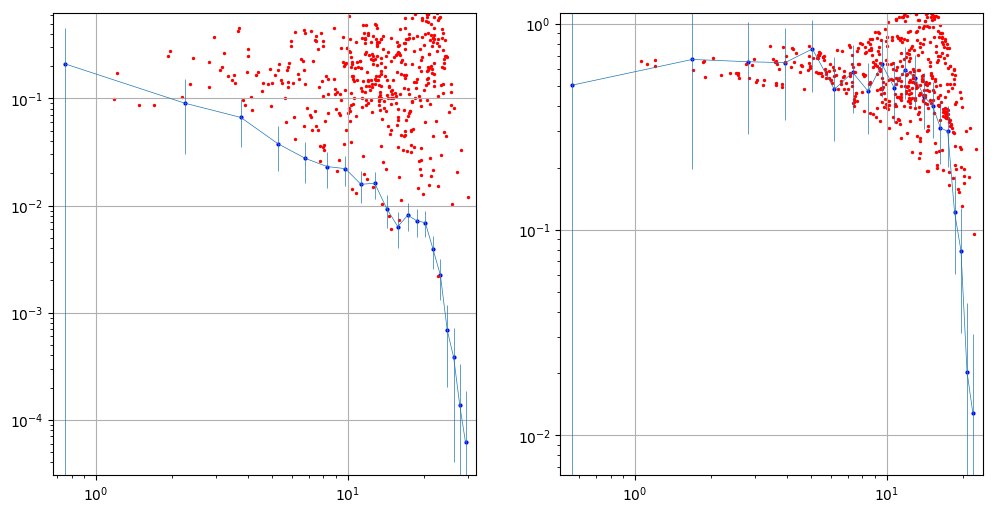

In [23]:
fig= PyPlot.figure(figsize=(12,6))
ax= PyPlot.subplot(121)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(minimum(r3d)*0.9, maximum(r3d)*1.1)
ax.set_ylim(minimum(ρ3d[ρ3d .> 0])*0.5,maximum(ρ3d)*3)
PyPlot.grid("on")
PyPlot.scatter(r3d, ρ3d , s=4, facecolor="blue" )
PyPlot.errorbar(r3d, ρ3d, yerr=2 .* err3d, linewidth=0.5)
PyPlot.scatter(rad3d, locdens3d , s=2, facecolor="red" )

ax= PyPlot.subplot(122)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.5,maximum(ρ2d)*1.5)
PyPlot.grid("on")
PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
PyPlot.scatter(rad2d, locdens2d , s=2, facecolor="red" )

PyPlot.show()

We try to fit the radial density (using MCMC?). It will be used later for the fractal dimension (including the radial density inside).

## Fitting the radial profile


In [24]:
## position from the gravity centered
struct _sc2dcentered
    nxy::Int
    xx::Array{Float64}
    yy::Array{Float64}
    radius::Array{Float64}
    dens::Array{Float64}
    nbin::Int
    radbin::Array{Float64}
    densbin::Array{Float64}
    densbinerr::Array{Float64}
end

## prior model / mcmc
mutable struct _mcmcCauchy
    Cmean::Float64
    Cdisp::Float64
    smean::Float64
    sdisp::Float64
    mmean::Float64
    mdisp::Float64
    nburnin::Int
    niter::Int
end

mutable struct _modelCauchy
    C::Float64
    s::Float64
    m::Float64 
end

mutable struct _mcCauchy
    C::Array{Float64}
    s::Array{Float64}
    m::Array{Float64}
end

In [25]:
## density and likelihood functions
function _fdens1(r, θ::_modelCauchy)
    r2= r*r
    s2= θ.s*θ.s
    val = θ.C / (1+r2/s2)^θ.m
    return(val)
end

function _fdens1log(r, θ::_modelCauchy)
    r2= r*r
    s2= exp(θ.s)*exp(θ.s)
    val = θ.C - θ.m * log(1+r2/s2)
    return(val)
end

## using local density for all points
function _likelihood2d(θ::_modelCauchy, oc::_sc2dcentered)
    χ2= 0
    for i in 1:oc.nxy
        desti= _fdens1(oc.radius[i], θ)
        χ2+= ((desti-oc.dens[i])^2)/oc.nxy     ## σ=1
    end
    p = min(1, exp(-χ2))
    return(p)
end

### binnned 2D density
function _likelihood2dbin(θ::_modelCauchy, oc::_sc2dcentered)
    χ2= 0
    for i in 1:oc.nbin
        desti= _fdens1(oc.radbin[i], θ)
        χ2+= ((desti-oc.densbin[i]) / oc.densbinerr[i])^2
    end
    # p = min(1, exp(-χ2))
    p= min(1, 1/χ2)
    return(p)
end

### binnned 2D/3D density log
### LOG
function _likelihood2dbinlog(θ::_modelCauchy, oc::_sc2dcentered)
    χ2= 0
    for i in 1:oc.nbin
        desti= _fdens1log(oc.radbin[i], θ)
        χ2+= ((desti-oc.densbin[i]) / 1)^2
        #println(i)
        #println(θ)
        #println(oc.densbin[i])
        #println(desti)
    end
    p = min(1, exp(-χ2))

    return(p)
end

_likelihood2dbinlog (generic function with 1 method)

# Metropolis-Hasting

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

proposal = norm(mu_current, proposal_width).rvs()

Next, you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed mu explaines the data better than your old mu, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed mu and a fixed sigma = 1). This can easily be computed by calculating the probability for each data point using scipy.stats.normal(mu, sigma).pdf(data) and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here):

likelihood_current = norm(mu_current, 1).pdf(data).prod() <br>
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod() <br>

# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current) <br>
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal) <br>

# Nominator of Bayes formula
p_current = likelihood_current * prior_current <br>
p_proposal = likelihood_proposal * prior_proposal <br>

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the mu_proposal has higher likelihood than mu_current. Eventually we'll get to mu = 0 (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

p_accept = p_proposal / p_current <br> 

we get an acceptance probability. You can already see that if p_proposal is larger, that probability will be > 1 and we'll definitely accept. However, if p_current is larger, say twice as large, there'll be a 50% chance of moving there:

accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

In [26]:
function _theta(mcmc::_mcmcCauchy, oc::_sc2dcentered, likelihood::Function, firstvalue::Bool)
    pC  = Normal(mcmc.Cmean, mcmc.Cdisp)
    pm  = Normal(mcmc.mmean, mcmc.mdisp)
    ps  = Normal(mcmc.smean, mcmc.sdisp)
    
    if firstvalue
        C= mcmc.Cmean 
        s= mcmc.smean
        m= mcmc.mmean
    else
        C = rand(pC)
        s = rand(ps)
        m = rand(pm) 
    end
       
    pdfC = pdf(pC,C)   
    pdfm = pdf(pm, m)  
    pdfs = pdf(ps, s)
        
    θ= _modelCauchy(C, s, m)
    
    pdfC = pdf(pC , C)
    pdfm = pdf(pm, m)
    pdfs = pdf(ps, s)
    ptotal = pdfC*pdfm*pdfs*likelihood(θ, oc)
    
    return(θ, ptotal) 
end


## next iteration
function _thetaiter(θi::_modelCauchy, mcmc::_mcmcCauchy, oc::_sc2dcentered, likelihood::Function)
    pC  = Normal(mcmc.Cmean, mcmc.Cdisp)
    pm  = Normal(mcmc.mmean, mcmc.mdisp)
    ps  = Normal(mcmc.smean, mcmc.sdisp)
    
    C_rw= Normal(θi.C, 0.5)
    s_rw= Normal(θi.s  , 0.5)
    m_rw= Normal(θi.m , 0.5)

    new_C = 0.
    new_m = 0
    new_s = 0
        
    new_C  = rand(C_rw)
    new_m =  rand(m_rw)     
    new_s =  rand(s_rw)
    
    θ= _modelCauchy(new_C, new_s, new_m)
   
    pdfC = pdf(pC , new_C)
    pdfm = pdf(pm, new_m)
    pdfs = pdf(ps, new_s)
    ptotal = pdfC*pdfm*pdfs*likelihood(θ, oc)
    
    return(θ, ptotal)
end

_thetaiter (generic function with 1 method)

In [27]:
## Main MCMC to estimate parameters
## firstvalue: true(set to mean), false(random from prior)
function main_mcmc(oc::_sc2dcentered, mcmc::_mcmcCauchy, likelihood::Function, firstvalue=false , verbose=true)
    let
        mci = _mcCauchy(zeros(Float64,0),zeros(Float64,0),zeros(Float64,0))
        mi, probi = _theta(mcmc, oc, likelihood, firstvalue)
        if verbose println("## Init done...") end
    
        niter = mcmc.niter
        nburn = mcmc.nburnin
        nchain = 1
        loopAgain = true
        burndone = false
        ηbest= 0 ; θbest= 0
        
        while loopAgain
            micurrent, probcurrent = _thetaiter(mi , mcmc, oc, likelihood)
   
        ### Metropolis-Hasting
            α = probcurrent / probi
            if α > rand() 
                mi = micurrent
                probi = probcurrent
                nchain += 1
                if (nchain%50000 == 0 && verbose ) println("### chain:",nchain) end
                if nchain > nburn && !burndone  nchain = 0 ; burndone = true end    ## burnin done
                if nchain > niter loopAgain = false end
                if burndone    
                    push!(mci.C, mi.C)
                    push!(mci.s, mi.s)
                    push!(mci.m, mi.m)
                end
            else
                nchain += 1
                if (nchain%50000 == 0 && verbose) println("### chain:",nchain) end
                if nchain > nburn && !burndone   nchain = 0 ; burndone = true end    ## burnin done
                if nchain > niter loopAgain = false end
                if burndone    
                    push!(mci.C, mi.C)
                    push!(mci.s, mi.s)
                    push!(mci.m, mi.m)
                end                    
            end
            
            η= likelihood(mi, oc)
            if η > ηbest
                ηbest= η
                θbest= mi
            end
        end
        
        if verbose println("## MCMC 2D fitting done.") end
        
        return(mci, θbest, ηbest)
    end
end

main_mcmc (generic function with 3 methods)

In [28]:
function _model_rad(radius, θ, densModel::Function)
    ρfit= [] 
    for i in 1:length(radius)
        ρ= densModel(radius[i], θ)
        push!(ρfit, ρ)
    end
    
    return(ρfit)
end

_model_rad (generic function with 1 method)

### Updated below with the src/ stable version... (main_mcmc renamed)

In [29]:
## main for 2D fitting
oc= CSV.read("test.csv", delim= ";")

## binned density
nbin= 20
r2d,ρ2d,err2d= _density2D(oc.Y, oc.Z, nbin)    ## binned radius
r3d,ρ3d,err3d= _density3D(oc.X, oc.Y, oc.Z, nbin)

## local density
nloc= 3
rad_2d, loc_2d= _locdens2d(oc.Y, oc.Z, nloc)    ## density estimated for each point
rad_3d, loc_3d= _locdens3d(oc.X,oc.Y, oc.Z, nloc)    

oc2d= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_2d, loc_2d , nbin , r2d, ρ2d, err2d )
##only 3D binned density
oc3d= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_3d, loc_3d , nbin , r3d, ρ3d, err3d )
oc3dlog= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_3d, loc_3d , nbin , r3d, log.(ρ3d), err3d ./ ρ3d )

## prior
C_mean= 15
C_disp= 10
s_mean= 10
s_disp= 5
m_mean= 3
m_disp= 2
#
nburnin= 50000
niter= 100000

pinit= _mcmcCauchy(C_mean, C_disp, s_mean, s_disp, m_mean, m_disp, nburnin, niter)

##
## if true it takes the mean as first step, otherwise random
println("## Running mcmc (2/3)D fitting")
println("## stars: $(length(oc.X))")

mci ,  θbest  = main_mcmc(oc2d, pinit, _likelihood2dbin, false) 


#println("## Running mcmc 3D fitting")
#mci ,  θbest  = main_mcmc(oc3d, pinit, _likelihood2dbin , false) 

@printf("## C: %3.3f (%3.3f) \n", median(mci.C), std(mci.C))
@printf("## s: %3.3f (%3.3f) \n", median(mci.s), std(mci.s))
@printf("## m: %3.3f (%3.3f) \n", median(mci.m), std(mci.m))
Cmed= median(mci.C)
smed= median(mci.s)
mmed= median(mci.m)
θmed= _modelCauchy(Cmed, smed, mmed)

println("##")
println("## Best solution")
@printf("## C: %3.3f \n", θbest.C)
@printf("## s: %3.3f \n", θbest.s)
@printf("## m: %3.3f \n", θbest.m)

## compute the radial distribution for the fitted law
## LOG solution
# θbest= _modelCauchy(exp(θbest.C), exp(θbest.s), exp(θbest.m))
# println(θbest)

ρ2dfit= _model_rad(r2d, θbest, _fdens1)
ρ2dmed= _model_rad(r2d, θmed, _fdens1)
#ρ3dfit= _model_rad(r3d, θbest, _fdens1)
#ρ3dmed= _model_rad(r3d, θmed, _fdens1)

println("## Done")

[352.9612495797691, 5.859387810041647, 2.9740462146016746]
## Running mcmc (2/3)D fitting
## stars: 520
## Init done...
### chain:50000
### chain:50000
### chain:100000
## MCMC 2D fitting done.
## C: 3.859 (7.188) 
## s: 6.808 (5.264) 
## m: 3.619 (1.662) 
##
## Best solution
## C: 0.983 
## s: 24.422 
## m: 5.103 
## Done


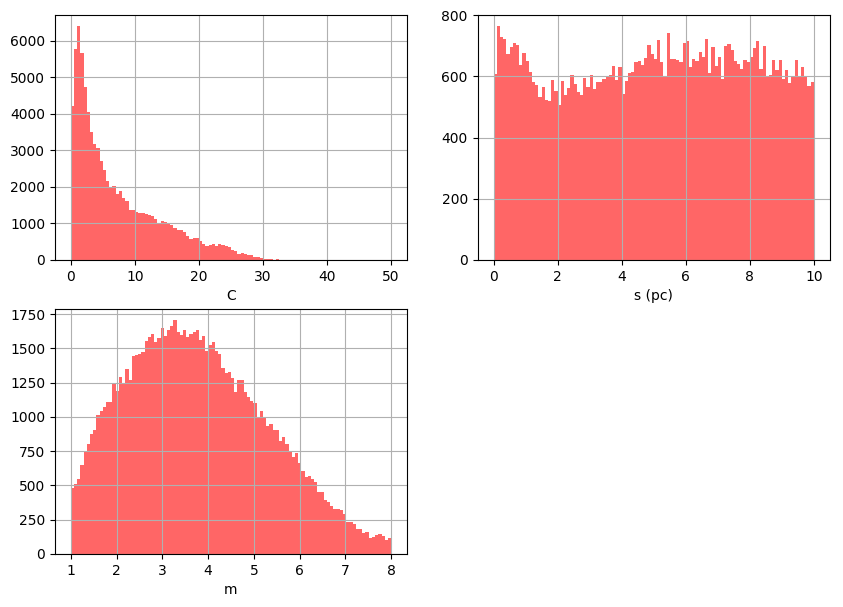

In [30]:
### Plot the results
###
fig = PyPlot.figure(figsize=(10,7))

ax = PyPlot.subplot(221)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(mci.C,nbins,range = [0,50], color = "r", alpha=0.6 , label = "C")
PyPlot.xlabel("C")


ax = PyPlot.subplot(222)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(mci.s,nbins,range = [0.,10], color = "r", alpha=0.6 , label = "C")
PyPlot.xlabel("s (pc)")

ax = PyPlot.subplot(223)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(mci.m,nbins,range = [1,8], color = "r", alpha=0.6 , label = "C")
PyPlot.xlabel("m")

PyPlot.show()

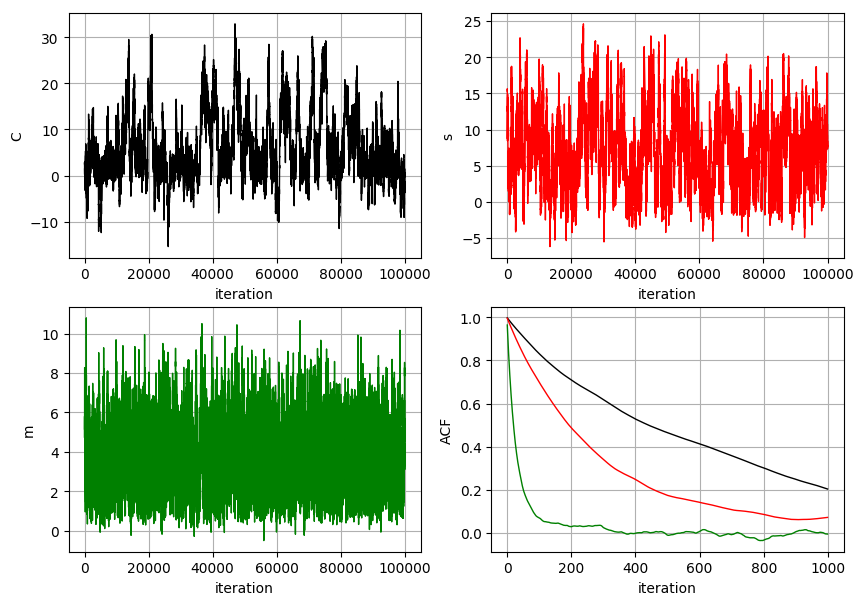

In [31]:
## Iterationss

fig = PyPlot.figure(figsize=(10,7))

ax = PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.xlabel("iteration")
PyPlot.ylabel("C")
PyPlot.plot(mci.C, "k-", linewidth= 1)
    
ax = PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.xlabel("iteration")
PyPlot.ylabel("s")
PyPlot.plot(mci.s, "r-", linewidth= 1)

ax = PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.xlabel("iteration")
PyPlot.ylabel("m")
PyPlot.plot(mci.m, "g-", linewidth= 1)

lags= collect(1:1000)
ax = PyPlot.subplot(224)
PyPlot.grid("on")
PyPlot.xlabel("iteration")
PyPlot.ylabel("ACF")
PyPlot.plot(StatsBase.autocor(mci.C, lags), "k-", linewidth= 1)
PyPlot.plot(StatsBase.autocor(mci.s, lags), "r-", linewidth= 1)
PyPlot.plot(StatsBase.autocor(mci.m, lags), "g-", linewidth= 1)

PyPlot.show()

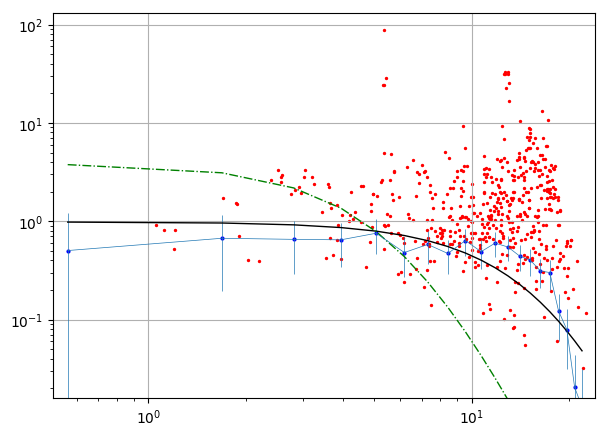

_modelCauchy(0.9825282764176176, 24.421539289808443, 5.102572747125281)


In [32]:
fig= PyPlot.figure(figsize=(7,5))

ax= PyPlot.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
ax.set_ylim(minimum(loc_2d[loc_2d .> 0])*0.5,maximum(loc_2d)*1.5)
PyPlot.grid("on")
PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
PyPlot.scatter(rad_2d, loc_2d , s=2, facecolor="red" )
PyPlot.plot(r2d, ρ2dfit, "k-", linewidth=1)
PyPlot.plot(r2d, ρ2dmed, "g-.", linewidth=1)

#ax.set_xlim(r3d[1]*0.9, r3d[end]*1.1)
#ax.set_ylim(minimum(ρ3d[ρ3d .> 0])*0.5,maximum(loc_3d)*1.5)
#PyPlot.scatter(r3d, ρ3d , s=4, facecolor="blue" )
#PyPlot.errorbar(r3d, ρ3d, yerr=2 .* err3d, linewidth=0.5)
#PyPlot.scatter(rad_3d, loc_3d , s=2, facecolor="red" )
#PyPlot.plot(r3d, ρ3dfit, "k-", linewidth=1)
#PyPlot.plot(r3d, ρ3dmed, "g-.", linewidth=1)

PyPlot.show()

println(θbest)

For the spatial parameters using mcmc the following items are important:
* _thetaiter : the dispersion of the random walk step to allow jump from local minima
* the prior should be well chosen to speed up the convergence
* eventually the initial value should be set (not random from prior)
* 3D local and binned density are not consistent yet
* Check ACF for the parameters
* The 3D local estimation for each stars does not look correct yet (or the binned estimation..)

--------
### Full automatization and check ...

In [33]:
## Estimate  prior parameters

function _priorGuess(rad, dens)
    
    m= 3
    mdisp= 2
    
    C= maximum(dens)
    Cdisp= C/2
    
    s= StatsBase.mean(rad, StatsBase.weights(convert(Array{Float64,1}, dens)))
    sdisp= s/2
    
    priorMean= _modelCauchy(C, s, m)
    priorDisp= _modelCauchy(Cdisp, sdisp, mdisp)
    
    return(priorMean, priorDisp)
end

## extract parameters
## 

function _extract_parameter(ocfile, ntest=10 , nbin=20, niter=10000 ,verbose=true)
    let 
        solC= []; sols= []; solm= []
        ηBest= 1e9 ; θBest= 0 
    
        oc= CSV.read(ocfile, delim= ";")
        if verbose println("## file $ocfile read...") end

        ## binned density
        r2d,ρ2d,err2d= _density2D(oc.Y, oc.Z, nbin)    ## binned radius
        r3d,ρ3d,err3d= _density3D(oc.X, oc.Y, oc.Z, nbin)
    
        ## local density
        ## not used yet...
        nloc= 3
        rad_2d, loc_2d= _locdens2d(oc.Y, oc.Z, nloc)    ## density estimated for each point
        rad_3d, loc_3d= _locdens3d(oc.X,oc.Y, oc.Z, nloc)    

        oc2d= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_2d, loc_2d , nbin , r2d, ρ2d, err2d )
        ##only 3D binned density
        oc3d= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_3d, loc_3d , nbin , r3d, ρ3d, err3d )
        oc3dlog= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_3d, loc_3d , nbin , r3d, log.(ρ3d), err3d ./ ρ3d )

        if verbose println("## Density profiles computed...") end
    
        ## prior
        ##
         prior, priorDisp= _priorGuess(r2d, ρ2d)
        if verbose
            println("## Prior Guess:")
            println(prior)
            println("## prior estimated...")
        end
        C_mean= prior.C ; C_disp= priorDisp.C
        s_mean= prior.s ; s_disp= priorDisp.s
        m_mean= prior.m ; m_disp= priorDisp.m

        nburnin= 10000

        pinit= _mcmcCauchy(C_mean, C_disp, s_mean, s_disp, m_mean, m_disp, nburnin, niter)


        ## AFC < 0.1
        ## if true it takes the mean as first step, otherwise random
        if verbose println("## Running mcmc (2/3)D fitting") end

        for i in 1:ntest        
            mci ,  θbest , ηbest = main_mcmc(oc2d, pinit, _likelihood2dbin, false, verbose)

            lags= collect(1:1000)
            acfC= StatsBase.autocor(mci.C, lags)[end]
            acfs= StatsBase.autocor(mci.s, lags)[end]
            acfm= StatsBase.autocor(mci.m, lags)[end]
            
            if verbose
                println("## test: $i")
                println(θbest)
                println("## Likelihood: $ηbest")
                println("## ACF(C,s,m): $acfC , $acfs , $acfm")
            end
            
            if abs(acfC) < 0.1 && abs(acfs) < 0.1 && abs(acfm) < 0.1
                push!(solC,abs(θbest.C))
                push!(sols,abs(θbest.s))
                push!(solm,abs(θbest.m))
                if ηbest < ηBest
                    ηBest= ηbest
                    θBest= θbest
                end
            end
        end
        
        println(solC)
        println(sols)
        println(solm)
        
        θerr= _modelCauchy(std(solC),std(sols),std(solm))

        if θBest.C<0 || θBest.s<0 || θBest.m<0
            θBest.C= abs(θBest.C) 
            θBest.s= abs(θBest.s)
            θBest.m= abs(θBest.m)
        end
        return(θBest, θerr)
    end
end


_extract_parameter (generic function with 5 methods)

In [34]:
ocfile= "test.csv"
ntest= 1000 ; nbin=20 ; niter=50000
θfit, θfiterr= _extract_parameter(ocfile, ntest, nbin, niter, true)


## file test.csv read...
[352.9612495797691, 5.859387810041647, 2.9740462146016746]
## Density profiles computed...
## Prior Guess:
_modelCauchy(0.754584911395763, 8.419523065093093, 3.0)
## prior estimated...
## Running mcmc (2/3)D fitting
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 1
_modelCauchy(0.9733335105783872, 21.493463116024714, 4.171544145623108)
## Likelihood: 0.008504306194720045
## ACF(C,s,m): -0.0062425090708965415 , 0.06568346403479942 , 0.00725553197294693
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 2
_modelCauchy(0.9597712859487161, 21.30369360392202, 3.8924876883630692)
## Likelihood: 0.008253344207014842
## ACF(C,s,m): -0.0007691636564825966 , 0.012553982670381353 , 0.021435331149176597
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 3
_modelCauchy(0.8885214806448626, 19.97169170585261, 3.6323028356850102)
## Likelihood: 0.008120382714774823
## ACF(C,s,m): 0.010014065858225264 , -0.11682646727893 , -0.0367

### chain:50000
## MCMC 2D fitting done.
## test: 32
_modelCauchy(0.9316202335338424, 24.259056101059198, 4.729460477039765)
## Likelihood: 0.00869810577137729
## ACF(C,s,m): 0.0008414179269468978 , 0.11900479093038674 , -0.00017154626228461998
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 33
_modelCauchy(0.9689928807660076, 21.71301034062332, 4.505850724355337)
## Likelihood: 0.00834773431668428
## ACF(C,s,m): 0.006832094760496334 , -0.06034546556783718 , 0.006268410451348559
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 34
_modelCauchy(0.9883171042677913, 22.238477189245653, 4.352545120581862)
## Likelihood: 0.008576785087264725
## ACF(C,s,m): 0.007360447717072039 , -0.003549439828073378 , -0.054915506794891475
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 35
_modelCauchy(0.9459569165302008, 21.82420844610091, 4.04377780015435)
## Likelihood: 0.008379271638365934
## ACF(C,s,m): 0.007253204321855952 , 0.08646654541311517 , -0

### chain:50000
## MCMC 2D fitting done.
## test: 64
_modelCauchy(0.9518546308772614, 23.889015667916613, 4.855355169239753)
## Likelihood: 0.008829710387934533
## ACF(C,s,m): -0.023755860630741206 , -0.005203390957177965 , 0.03585728222149398
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 65
_modelCauchy(1.1022388673427157, 24.392298112849318, 5.5586400615751375)
## Likelihood: 0.008500470407871712
## ACF(C,s,m): 0.00262658647966952 , 0.07223369687895194 , 0.043961389682403235
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 66
_modelCauchy(0.9318349293301543, 21.174437168784507, 3.9363919231764886)
## Likelihood: 0.008384383656468125
## ACF(C,s,m): 0.0006799747028895976 , 0.03175072911721954 , 0.01510045770456938
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 67
_modelCauchy(0.9851574794831877, 22.064317484233683, 4.297671876405442)
## Likelihood: 0.00855587164015732
## ACF(C,s,m): -0.0021750696145174495 , -0.06163446037298289 , 

### chain:50000
## MCMC 2D fitting done.
## test: 96
_modelCauchy(0.9333831428871959, 23.18790286296115, 4.848479859629941)
## Likelihood: 0.00858718035980526
## ACF(C,s,m): 0.0008622087885100571 , -0.02670128707630811 , -0.054269397314049624
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 97
_modelCauchy(0.9786921200890892, 24.367113442357176, 4.89022050920077)
## Likelihood: 0.008758045178447024
## ACF(C,s,m): -0.004902642086498907 , -0.05077944529154388 , 0.07406435426353274
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 98
_modelCauchy(0.9699953643621201, 20.08665330454869, 3.8836802108266886)
## Likelihood: 0.008256025370879362
## ACF(C,s,m): 0.002641640813403324 , 0.018842835446490135 , -0.017895657535755605
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 99
_modelCauchy(0.9712788032107715, 21.491255150870476, 4.153915129552395)
## Likelihood: 0.008499879193859894
## ACF(C,s,m): -0.008879050024058035 , -0.020239346572718496 ,

### chain:50000
## MCMC 2D fitting done.
## test: 128
_modelCauchy(1.0746920819134318, 22.151898955356017, 4.635091188230297)
## Likelihood: 0.008429788835883066
## ACF(C,s,m): -0.00304397610439139 , 0.03291626844168251 , -0.025313309128545992
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 129
_modelCauchy(1.0191417072604487, 19.760047122805556, 3.8868210271917136)
## Likelihood: 0.00818288877756931
## ACF(C,s,m): -0.007629540248217698 , 0.10592375971482923 , 0.024647940528822174
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 130
_modelCauchy(0.9602957449641991, 19.76906629178419, 3.809573768782559)
## Likelihood: 0.008172044017868765
## ACF(C,s,m): 0.00038680008547379083 , -0.0302431283232156 , -0.003294558090660509
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 131
_modelCauchy(0.9930115986665483, 18.305087423817298, 3.234059548818951)
## Likelihood: 0.007898772545143762
## ACF(C,s,m): -0.01184509370756501 , -0.0672726384957841

### chain:50000
## MCMC 2D fitting done.
## test: 160
_modelCauchy(0.9805818649328587, 23.25070027835237, 4.526797022114302)
## Likelihood: 0.00858560712174997
## ACF(C,s,m): 0.005404756458680195 , 0.07531891900585116 , -0.042625464893683795
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 161
_modelCauchy(1.0244704041868313, 25.333946623744936, 5.354845032988042)
## Likelihood: 0.008848935944676355
## ACF(C,s,m): -0.01266763761507607 , -0.11982016654081265 , 0.01374806475127081
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 162
_modelCauchy(1.0035468430213832, 20.016593519942383, 3.9748985615502344)
## Likelihood: 0.008196860848129395
## ACF(C,s,m): 0.004584487328980221 , -0.04276165119295034 , 0.002076277372578233
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 163
_modelCauchy(1.0493468428011445, 22.254654006423944, 4.710236845414055)
## Likelihood: 0.008468432943012751
## ACF(C,s,m): 0.01048666094352724 , 0.019415984007254403 , 

### chain:50000
## MCMC 2D fitting done.
## test: 192
_modelCauchy(0.9857808750441086, 22.934977723203062, 4.631601854630656)
## Likelihood: 0.008705687762530213
## ACF(C,s,m): -0.00796567663359199 , 0.005186290826287378 , -0.04242702054404129
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 193
_modelCauchy(0.9872532624945785, 22.708488109175335, 4.429866983651885)
## Likelihood: 0.008582971756533648
## ACF(C,s,m): -0.005800016510935705 , 0.05329524622693502 , -0.012966815124970157
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 194
_modelCauchy(0.9107564312530684, 22.536128447107604, 4.341017950543037)
## Likelihood: 0.00857976296958768
## ACF(C,s,m): -0.003041057148870284 , 0.06392142034900816 , 0.058969155967140766
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 195
_modelCauchy(0.9666464570881346, 19.36977333471934, 3.5342625947816257)
## Likelihood: 0.008145477105218055
## ACF(C,s,m): 0.006560923986064656 , 0.07849644847445739 

### chain:50000
## MCMC 2D fitting done.
## test: 224
_modelCauchy(0.9556235103556341, 19.754380630220933, 3.858502653893858)
## Likelihood: 0.008096940323076167
## ACF(C,s,m): -0.007922918224511872 , -0.06097469413556096 , 0.003035687476586656
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 225
_modelCauchy(1.049703110057016, 18.38410213624217, 3.450572320803628)
## Likelihood: 0.007963830849289318
## ACF(C,s,m): 0.011169229912962542 , -0.06710480187190114 , -0.006225574126017362
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 226
_modelCauchy(0.9820003998468221, 20.274373852359542, 3.7190443540297693)
## Likelihood: 0.008217803299969973
## ACF(C,s,m): -0.008554004103238108 , -0.013488191091260442 , -0.009746198868452427
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 227
_modelCauchy(0.9896465745245164, 20.07413439618239, 3.705988467436437)
## Likelihood: 0.00822189600499799
## ACF(C,s,m): -0.0036540515731393326 , 0.07565071601014

### chain:50000
## MCMC 2D fitting done.
## test: 256
_modelCauchy(1.0575745967164085, 20.094052929248573, 4.009888033249671)
## Likelihood: 0.008196509055259349
## ACF(C,s,m): -0.007182194936172108 , 0.04386723476745142 , 0.03234506836810062
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 257
_modelCauchy(0.9746082552264157, 23.19195230630569, 4.775567213994205)
## Likelihood: 0.008736909506081508
## ACF(C,s,m): -0.001927304812019532 , 0.06719103477387336 , 0.021881310488929762
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 258
_modelCauchy(0.9809575937461491, 21.372202874629984, 4.364533269947152)
## Likelihood: 0.00837661121703317
## ACF(C,s,m): 0.003307347115397453 , -0.007851758980791452 , -0.04409779874363055
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 259
_modelCauchy(1.0963691046444253, 21.165912418436008, 4.466238727769465)
## Likelihood: 0.008182029070310117
## ACF(C,s,m): 0.010017117621911363 , -0.08298128308683277 ,

### chain:50000
## MCMC 2D fitting done.
## test: 288
_modelCauchy(1.0609004268733255, 21.238586444957022, 4.325431773568502)
## Likelihood: 0.008356723138373262
## ACF(C,s,m): -0.0015891628855743663 , -0.12106538586361346 , 0.015035189261776511
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 289
_modelCauchy(1.003384466950479, 21.530642626472815, 4.183314788564005)
## Likelihood: 0.008474680816693836
## ACF(C,s,m): 0.012050686713255772 , -0.020954835540059696 , -0.0544920887466087
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 290
_modelCauchy(0.9041695322133947, 22.88466973439172, 4.785150158846286)
## Likelihood: 0.008361910306237168
## ACF(C,s,m): 0.009195832646011367 , 0.06096382946321731 , -0.0355627289441284
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 291
_modelCauchy(0.9911082371020584, 21.317160773652617, 4.332807247098166)
## Likelihood: 0.008402765542403216
## ACF(C,s,m): -0.011219276851659512 , -0.1338872002576882 ,

### chain:50000
## MCMC 2D fitting done.
## test: 320
_modelCauchy(0.9829067117231727, 21.285711979980896, 4.255001971873739)
## Likelihood: 0.008443977290776505
## ACF(C,s,m): -0.011397693273391052 , 0.015886953220624753 , -0.03291913313981361
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 321
_modelCauchy(0.9295744488138379, 21.159875035979056, 3.9855892936406234)
## Likelihood: 0.008409495050053277
## ACF(C,s,m): 0.0022063089404056003 , -0.019556959278325924 , 0.01768384872066937
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 322
_modelCauchy(0.9903974212799285, 19.322756245827335, 3.785224091202633)
## Likelihood: 0.008055125725468291
## ACF(C,s,m): -0.004675051178352595 , -0.05865097212262264 , 0.023788511575626864
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 323
_modelCauchy(0.9918039736392796, 21.161382145474786, 4.22843962649865)
## Likelihood: 0.008427258640235366
## ACF(C,s,m): 0.00820347833665677 , -0.055844961008397

### chain:50000
## MCMC 2D fitting done.
## test: 352
_modelCauchy(0.930298867072832, 20.402350524822193, 3.747488021752571)
## Likelihood: 0.008274956976425748
## ACF(C,s,m): -0.005162127118448832 , 0.066599518936947 , -0.05149627113415918
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 353
_modelCauchy(0.8360862024369179, 22.593710505689405, 4.142613370683268)
## Likelihood: 0.008294494507393215
## ACF(C,s,m): 0.0009505720336842383 , 0.07711253359230473 , -0.016418619552097797
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 354
_modelCauchy(0.836148699159974, 23.620345271589848, 4.3894936962756335)
## Likelihood: 0.008401040977168829
## ACF(C,s,m): -0.0038431346982905814 , -0.042151102494856395 , 0.03223601842042423
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 355
_modelCauchy(0.9819300574836154, 21.6170462672212, 4.346826208895298)
## Likelihood: 0.008496339930204705
## ACF(C,s,m): 0.0023254376452509266 , -0.04449313834749252 

### chain:50000
## MCMC 2D fitting done.
## test: 384
_modelCauchy(1.1020428230204893, 19.020592149959928, 3.6815841707138524)
## Likelihood: 0.007940772968858409
## ACF(C,s,m): 0.007120240567386776 , -0.1294763427814457 , 0.05267885946782174
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 385
_modelCauchy(0.9487898669187542, 19.88544974274683, 3.6244915809135616)
## Likelihood: 0.008204596795840688
## ACF(C,s,m): -0.008560744488666784 , 0.038886241868123395 , -0.044021683628686734
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 386
_modelCauchy(0.975965632737732, 19.852051929751813, 3.8150608541032063)
## Likelihood: 0.008228776860614835
## ACF(C,s,m): -0.010001454868099382 , 0.0846665897733493 , -0.011561331667347102
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 387
_modelCauchy(0.9846504991998579, 20.106003783155188, 3.7523222018960976)
## Likelihood: 0.008269199479500704
## ACF(C,s,m): 0.0023357492394651107 , -0.02286404874605

### chain:50000
## MCMC 2D fitting done.
## test: 416
_modelCauchy(0.9946272481521046, 21.474327371844165, 4.372481463155916)
## Likelihood: 0.008437503210732342
## ACF(C,s,m): 0.0005661117648317321 , -0.03430985377975756 , 0.016016317941711482
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 417
_modelCauchy(1.0301139183241934, 20.375519435189858, 4.1382529371684775)
## Likelihood: 0.00821144515101218
## ACF(C,s,m): -0.0017972900509790678 , 0.06231904019910411 , 0.043960246917826185
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 418
_modelCauchy(0.8666834269072474, 20.843892101686432, 3.839677185890457)
## Likelihood: 0.008188933381920267
## ACF(C,s,m): 0.002869335494086855 , -0.028370712705842675 , 0.015947121579988864
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 419
_modelCauchy(0.8981210570551134, 21.49567875437932, 3.949115320121393)
## Likelihood: 0.008351315543198273
## ACF(C,s,m): 0.008572819280210626 , 0.0315572966342705

### chain:50000
## MCMC 2D fitting done.
## test: 448
_modelCauchy(0.9492644659774221, 24.14059744595168, 4.824349398481273)
## Likelihood: 0.008805876029507347
## ACF(C,s,m): -0.000474708147080527 , 0.10384579733925364 , -0.04593033390097608
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 449
_modelCauchy(1.0649618097972948, 20.713067890651033, 4.350596303893118)
## Likelihood: 0.008131267956806708
## ACF(C,s,m): 0.00575763632704269 , 0.06777622278865007 , 0.009947787946961013
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 450
_modelCauchy(0.9120642464609294, 19.857882821220027, 3.6522665522936633)
## Likelihood: 0.008164008666381626
## ACF(C,s,m): 0.0034444689618493693 , 0.10423749958333965 , -0.026294508227425947
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 451
_modelCauchy(1.0350810663849335, 20.69042838887298, 4.207292681366249)
## Likelihood: 0.008282612558410094
## ACF(C,s,m): -0.006707055834869225 , 0.006144307428294907 

### chain:50000
## MCMC 2D fitting done.
## test: 480
_modelCauchy(0.932254808772377, 21.151511441914145, 4.118401859399635)
## Likelihood: 0.008386990219028154
## ACF(C,s,m): -0.019555664419575923 , -0.1475211186170147 , -0.03752748517394117
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 481
_modelCauchy(0.9612661670960378, 24.23067771476146, 5.023046462007675)
## Likelihood: 0.008880651144119456
## ACF(C,s,m): 0.006879262453066793 , -0.0317323992416702 , 0.009467184364817433
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 482
_modelCauchy(0.9474167656352932, 25.021396100655192, 5.305561600550224)
## Likelihood: 0.008964042391385223
## ACF(C,s,m): -0.0032267468321969545 , -0.019236070267156777 , -0.029099588843987508
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 483
_modelCauchy(0.9198848974167315, 21.411277937230157, 3.862543536373658)
## Likelihood: 0.008247660775679087
## ACF(C,s,m): 0.006321562938367135 , -0.0232050224754697

### chain:50000
## MCMC 2D fitting done.
## test: 512
_modelCauchy(0.9963806965549877, 22.941225295000795, 4.650946881603351)
## Likelihood: 0.00869798703301195
## ACF(C,s,m): 0.015464432502237844 , 0.005954381348100372 , 0.01735102118976042
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 513
_modelCauchy(0.9658413033620808, 20.554446697379838, 3.728496937739264)
## Likelihood: 0.008195670696969682
## ACF(C,s,m): 0.00032501069329543336 , -0.04096062239257364 , -0.005841870425073878
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 514
_modelCauchy(0.9165203282257018, 22.558674359669098, 4.567275757404823)
## Likelihood: 0.008519778231342865
## ACF(C,s,m): 0.0045292592033415935 , 0.07318001197532484 , 0.03407656825599854
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 515
_modelCauchy(1.0375116772352797, 22.79751943994847, 4.803203191562416)
## Likelihood: 0.008599299363269211
## ACF(C,s,m): 0.0029033476084078615 , 0.024243457905151766

### chain:50000
## MCMC 2D fitting done.
## test: 544
_modelCauchy(0.936915933779169, 21.048153631672122, 4.08914964834934)
## Likelihood: 0.008383162432961003
## ACF(C,s,m): 0.004530787468681797 , 0.0869163505902636 , 0.01131420206200516
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 545
_modelCauchy(1.0604055533813583, 23.16996818066389, 4.643201204441712)
## Likelihood: 0.008400556260863504
## ACF(C,s,m): 0.004754424237809421 , 0.11347530634632817 , 0.009503747239671043
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 546
_modelCauchy(0.9550439519135757, 23.172949749963074, 4.477727935411327)
## Likelihood: 0.008613736596234345
## ACF(C,s,m): -0.005098692768519285 , 0.09041955964361906 , 0.004777819786525145
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 547
_modelCauchy(1.0027556620053983, 26.208921121169663, 5.849127434400454)
## Likelihood: 0.009069340923792114
## ACF(C,s,m): -0.002157035239682028 , 0.05358961856749709 , 0.00

### chain:50000
## MCMC 2D fitting done.
## test: 576
_modelCauchy(0.9098138379148762, 24.58382115396249, 5.360986197456961)
## Likelihood: 0.008592980773670452
## ACF(C,s,m): 0.007398708735731882 , 0.025731692988090915 , 0.03838536615058484
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 577
_modelCauchy(0.9487033330060333, 20.983307938234013, 4.1188414208882795)
## Likelihood: 0.008369595864773519
## ACF(C,s,m): -0.0015305156198549951 , -0.08940525132798328 , 0.007003895977437719
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 578
_modelCauchy(0.9939417923066004, 20.39672060216389, 3.7775872945518607)
## Likelihood: 0.008242757362624507
## ACF(C,s,m): -0.00596550513317626 , 0.09731496745245677 , 0.024182738972661533
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 579
_modelCauchy(0.9911991952315405, 19.307163601928373, 3.7187151032789143)
## Likelihood: 0.008119952963047083
## ACF(C,s,m): 0.004577385450409454 , -0.0066307470059570

### chain:50000
## MCMC 2D fitting done.
## test: 608
_modelCauchy(0.9437376337529317, 25.504852977137325, 5.903347221806688)
## Likelihood: 0.0085501658312988
## ACF(C,s,m): -0.008306212628760733 , 0.1115951332511464 , 0.0016342821734303477
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 609
_modelCauchy(1.04516513023995, 21.944319909089163, 4.552313526998123)
## Likelihood: 0.008472079290980974
## ACF(C,s,m): -0.004627567212919779 , 0.023778961006443805 , -0.017008148400133052
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 610
_modelCauchy(0.9558067253543375, 21.791651790383717, 4.331005002668539)
## Likelihood: 0.008524292800645475
## ACF(C,s,m): 0.002340320196141339 , -0.06546517258791242 , 0.0014042495908171057
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 611
_modelCauchy(1.0566600498814374, 22.04738293496227, 4.610123662725437)
## Likelihood: 0.008454668852291548
## ACF(C,s,m): 0.0021234987457253167 , -0.03291063468806272 

### chain:50000
## MCMC 2D fitting done.
## test: 640
_modelCauchy(0.9678140475484805, 19.585449659330006, 3.711126331418452)
## Likelihood: 0.008189440069026452
## ACF(C,s,m): -0.008978023189705652 , -0.04973664588920364 , -0.004824809672187986
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 641
_modelCauchy(0.9666417079046187, 19.814990975705346, 3.7682150396151455)
## Likelihood: 0.008228853655670795
## ACF(C,s,m): -0.007653707524122054 , -0.0968418542228324 , -0.014473297400421154
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 642
_modelCauchy(1.0279819738570068, 19.60839088760547, 3.9102631728494623)
## Likelihood: 0.00809952241616172
## ACF(C,s,m): 0.006411359790670548 , -0.032742974715479614 , 0.0021145779570897745
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 643
_modelCauchy(0.9011424230454279, 22.394752704289512, 4.156248505780972)
## Likelihood: 0.00844182476696327
## ACF(C,s,m): -0.007581407117695644 , -0.150566589842

### chain:50000
## MCMC 2D fitting done.
## test: 672
_modelCauchy(0.968972156389533, 23.324805862431333, 4.605108561039485)
## Likelihood: 0.008697829669495144
## ACF(C,s,m): -0.006856610245114601 , 0.02933079548370291 , -0.016065728644118874
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 673
_modelCauchy(1.0176482913934266, 20.355301095040875, 3.831533915464983)
## Likelihood: 0.00825141459713612
## ACF(C,s,m): -0.0010855448091631628 , -0.0401869531828768 , -0.020486983070782547
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 674
_modelCauchy(0.9689240779930033, 20.318079289987853, 3.7703103012969543)
## Likelihood: 0.008289405816267673
## ACF(C,s,m): -0.004721321091553458 , -0.08916906557469025 , -0.04475602792508709
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 675
_modelCauchy(0.9498077750119877, 21.425781630582666, 3.96026650594563)
## Likelihood: 0.008355650668314106
## ACF(C,s,m): 0.0019019539207461114 , -0.04345737836832

### chain:50000
## MCMC 2D fitting done.
## test: 704
_modelCauchy(0.98512559812121, 20.813384001782012, 4.056541153634312)
## Likelihood: 0.008401826832594574
## ACF(C,s,m): -0.008229405584677751 , -0.07014445749672683 , 0.020905926566769557
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 705
_modelCauchy(1.002811394573045, 21.232021298429274, 4.21060731615333)
## Likelihood: 0.00845666371972129
## ACF(C,s,m): 0.0002545580927440401 , 0.0757191339792902 , -0.015577273507741012
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 706
_modelCauchy(0.9973137853474675, 22.933019825182107, 5.013895375922483)
## Likelihood: 0.008420333014987005
## ACF(C,s,m): -0.0002934881022168433 , 0.0004677437361760285 , 0.014846359986417758
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 707
_modelCauchy(1.0066866863746342, 20.959685343470024, 4.214426081870575)
## Likelihood: 0.008375442101678947
## ACF(C,s,m): 0.0010465900302695625 , -0.05401697503998955

### chain:50000
## MCMC 2D fitting done.
## test: 736
_modelCauchy(0.963149465318668, 22.244629404998648, 4.232250530401849)
## Likelihood: 0.00850448335130694
## ACF(C,s,m): -0.005300512381435803 , 0.10200357556831563 , 0.06538617837943941
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 737
_modelCauchy(1.0663372997488103, 20.95319408099882, 4.1091769412903325)
## Likelihood: 0.008269114140258481
## ACF(C,s,m): -0.0168590873060377 , -0.06021927162466472 , 0.0266370807757513
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 738
_modelCauchy(0.9605348066988281, 20.610493601563334, 3.866421253415925)
## Likelihood: 0.00835102263754859
## ACF(C,s,m): -0.007265126872006321 , 0.031991029168994885 , -0.01590932201458224
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 739
_modelCauchy(1.004640324394504, 19.24257804161989, 3.6967222271810725)
## Likelihood: 0.008125366053446768
## ACF(C,s,m): 0.006229252395441035 , 0.0303620587061398 , 0.0194

### chain:50000
## MCMC 2D fitting done.
## test: 768
_modelCauchy(0.9004143391515471, 23.044576750714658, 4.369236481648622)
## Likelihood: 0.008563877781838316
## ACF(C,s,m): -0.009148274415906984 , -0.2290241354021685 , -0.000474898230881184
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 769
_modelCauchy(0.9172177627459678, 21.556769642055215, 4.088881265032005)
## Likelihood: 0.008451304921783274
## ACF(C,s,m): 0.0072723442285303475 , 0.0536244268044137 , -0.05053088704096044
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 770
_modelCauchy(0.9081415303820866, 21.96736316082692, 4.4642934412582225)
## Likelihood: 0.008303449576584413
## ACF(C,s,m): 0.021840347945638706 , 0.029695839523882682 , 0.054516751931628436
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 771
_modelCauchy(0.990737936563321, 20.98199254812426, 4.076996078587279)
## Likelihood: 0.008429476916964225
## ACF(C,s,m): 0.00784674415834675 , -0.016970793483519122 ,

### chain:50000
## MCMC 2D fitting done.
## test: 800
_modelCauchy(1.043703520838305, 22.24694448255671, 4.397390502789865)
## Likelihood: 0.008436072650112418
## ACF(C,s,m): 0.015830995395077378 , 0.01780533206238963 , 0.018803761769934906
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 801
_modelCauchy(0.9536049795076987, 19.117530169661933, 3.541469387647676)
## Likelihood: 0.008104198281959431
## ACF(C,s,m): 0.0014810213835923956 , 0.06905159174026622 , -0.006763346450218336
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 802
_modelCauchy(1.0231877332359083, 20.979047733384004, 4.089951747989036)
## Likelihood: 0.008390601619545905
## ACF(C,s,m): 0.0025669118890645237 , 0.10442585686172234 , -0.009530719283488932
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 803
_modelCauchy(0.9913887560532708, 19.872141041442017, 3.7935582154185137)
## Likelihood: 0.008254400897252805
## ACF(C,s,m): 0.00354356857683159 , 0.01028500237467333 ,

### chain:50000
## MCMC 2D fitting done.
## test: 832
_modelCauchy(0.8295138771330445, 24.748026632846774, 4.886194765513795)
## Likelihood: 0.008581622372868417
## ACF(C,s,m): 0.004896217433346914 , 0.003664600967686502 , -0.060799773619916474
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 833
_modelCauchy(0.9544437159932376, 19.80857517703476, 3.717451126151854)
## Likelihood: 0.008226587436383074
## ACF(C,s,m): -0.005265567133160313 , 0.10823515157657887 , 0.004312462219404209
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 834
_modelCauchy(0.9214449893995379, 23.253619211760512, 4.4333891396329905)
## Likelihood: 0.00858988392213451
## ACF(C,s,m): -0.002801269297290384 , -0.1248036339268719 , 0.00257044424067032
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 835
_modelCauchy(0.9242232565801819, 21.704295899723135, 4.240460229893039)
## Likelihood: 0.008471658576905202
## ACF(C,s,m): 0.005778714100378314 , 0.03899966092074469 ,

### chain:50000
## MCMC 2D fitting done.
## test: 864
_modelCauchy(0.9686196112522993, 20.35359136070521, 3.9196815124384496)
## Likelihood: 0.00831880491667813
## ACF(C,s,m): -0.0031032384410895745 , -0.0633329474513398 , -0.0038836643297109714
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 865
_modelCauchy(1.020820810309798, 20.928618363178035, 4.2349368937829865)
## Likelihood: 0.00835275255595659
## ACF(C,s,m): 0.023009585039214017 , -0.10677492244163236 , 0.002833248066611253
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 866
_modelCauchy(1.0732128428918126, 23.500496242863974, 5.097821430736628)
## Likelihood: 0.008579232320570446
## ACF(C,s,m): -0.014123527697574518 , -0.007057771240241181 , -0.0018898317403492231
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 867
_modelCauchy(1.0345630283464968, 20.325068050395778, 3.8919952923189087)
## Likelihood: 0.008261540772832768
## ACF(C,s,m): -0.01427809180343846 , -0.00200495679

### chain:50000
## MCMC 2D fitting done.
## test: 896
_modelCauchy(0.9655483533076068, 23.90867320399548, 4.9794639249678285)
## Likelihood: 0.008832496034114538
## ACF(C,s,m): -0.010014125928484559 , 0.05849915959242876 , 0.03803150065900565
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 897
_modelCauchy(1.0221429708489578, 23.712526282422935, 4.867578850182159)
## Likelihood: 0.00871758747088624
## ACF(C,s,m): -0.008694902430582928 , -0.009696792331299945 , -0.045578128181166216
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 898
_modelCauchy(1.0092109557601765, 22.622431586643643, 4.702491047200528)
## Likelihood: 0.008621227470176655
## ACF(C,s,m): 0.006142748061978699 , -0.05174976661894756 , -0.06494819185974067
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 899
_modelCauchy(0.9851981087365262, 20.534810293067647, 4.08339765617437)
## Likelihood: 0.008292798430277713
## ACF(C,s,m): -0.0018358470387333761 , -0.067405964432424

### chain:50000
## MCMC 2D fitting done.
## test: 928
_modelCauchy(0.928377181682053, 20.375434314880593, 3.737471466292462)
## Likelihood: 0.008267471589313447
## ACF(C,s,m): -0.01031904864552737 , 0.02545784340850482 , -0.044885624737958804
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 929
_modelCauchy(0.9029016101757746, 20.56422872531224, 3.652864568987436)
## Likelihood: 0.008152986068509248
## ACF(C,s,m): -0.0031802021758917886 , 0.04379324869812875 , 0.017962420440395147
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 930
_modelCauchy(0.9926243656085878, 20.655139749868397, 4.123117296304211)
## Likelihood: 0.008318052749169068
## ACF(C,s,m): 0.00016655119889336182 , 0.012583212064824677 , 0.007187278344142756
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 931
_modelCauchy(1.0247364326037613, 21.817284734739555, 4.558372702657212)
## Likelihood: 0.008431975325516677
## ACF(C,s,m): 0.011612743565777248 , -0.0728036439233198

### chain:50000
## MCMC 2D fitting done.
## test: 960
_modelCauchy(0.9521008948560743, 21.492555629952072, 4.063274058573441)
## Likelihood: 0.008458693020621473
## ACF(C,s,m): -0.011954340125039726 , -0.06787056246471779 , -0.0029948855787719298
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 961
_modelCauchy(0.9542655632646229, 18.975995085421232, 3.4462672697903787)
## Likelihood: 0.008080667184479962
## ACF(C,s,m): -0.010316779608826892 , -0.09510675159613756 , 0.04711133815851867
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 962
_modelCauchy(0.9403045371285106, 25.975189661358932, 5.469521365596236)
## Likelihood: 0.00906384303476889
## ACF(C,s,m): -0.0026322173677039143 , 0.06442763509254991 , 0.0003984181264113096
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 963
_modelCauchy(1.0168302066629964, 21.530798882068858, 4.179028708851879)
## Likelihood: 0.008437280035900009
## ACF(C,s,m): -0.005185366387229681 , 0.073974241562

### chain:50000
## MCMC 2D fitting done.
## test: 992
_modelCauchy(1.0136334394366437, 22.182727205482063, 4.4648491735991005)
## Likelihood: 0.008580293557705659
## ACF(C,s,m): 0.0001268012833254531 , -0.0819914043029752 , -0.04011663052189025
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 993
_modelCauchy(0.8913268720321208, 22.012291310067727, 4.203384940365364)
## Likelihood: 0.008456486263370405
## ACF(C,s,m): -0.0063988909434011705 , -0.009374631431772907 , 0.03578431889580492
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 994
_modelCauchy(0.9725308937299924, 21.03135134491322, 4.086521267570799)
## Likelihood: 0.008436150518585156
## ACF(C,s,m): 0.006938178992163455 , -0.12318063099496195 , -0.03366932042340568
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 995
_modelCauchy(0.9290504768688497, 19.032841680758327, 3.5081018834271167)
## Likelihood: 0.008040166064090812
## ACF(C,s,m): -0.004109876229383924 , -0.0341030776339

Any[0.9733335105783872, 0.9597712859487161, 0.9262923832829691, 1.0626388966632323, 0.9416153245639889, 0.9403403419699816, 1.0530324095069796, 1.0239691604492493, 0.9931253919408751, 0.9812033443338783, 0.9253880444915668, 0.9833243345648505, 1.0344581873567642, 1.0119775578837265, 1.0431798852444882, 0.9863621475174136, 1.0533015307817777, 0.918777698667674, 0.8667237568398322, 0.9805460534522648, 0.9316188124021437, 1.0120496014774734, 0.8969748512565123, 1.0237873606055201, 1.0412623613676844, 1.009524619870182, 1.0022042347850564, 0.9689928807660076, 0.9883171042677913, 0.9459569165302008, 1.0627246176888596, 0.9088178558567996, 1.02496562352087, 1.0152586436942803, 0.9215736796933509, 0.8819098076119238, 0.9048126634276707, 0.9431832155740338, 1.0140721357983584, 1.0359470034026208, 0.9572622606426181, 0.9711618759470866, 1.0301868257483227, 0.9475834797920945, 0.9977317380784843, 0.8859053524072001, 0.9023829166029889, 0.9312913835447924, 0.9166124761312137, 0.9358755270739932, 

Any[21.493463116024714, 21.30369360392202, 20.94165573702609, 22.013527647911985, 19.520007829382646, 22.591378952736505, 20.467935872762485, 20.537371506812306, 22.699327941815802, 20.383840355519066, 20.09852506234974, 19.442348985275355, 24.02254508955463, 22.508422320517763, 20.465358869111892, 19.222649142382636, 25.44853541666978, 22.2607865381615, 23.660934054992055, 20.38281676116689, 21.791240691788612, 21.303472162109525, 19.229017755690812, 22.87965441997463, 21.93472146373484, 20.792856323329566, 23.52094878737111, 21.71301034062332, 22.238477189245653, 21.82420844610091, 22.821632945711603, 20.701223082856963, 22.180666848632985, 23.805978304184944, 19.983223423959174, 20.3426908648985, 21.125260802486856, 19.233209570967023, 19.755968700200217, 19.76438835446598, 20.699485342094125, 21.060243097441248, 24.44663227721498, 21.857200971463914, 18.831265206628263, 19.952962984205328, 21.591888915801352, 21.23746459613983, 21.698602347340646, 21.384836678124064, 20.34487378508

 20.536327466571645, 19.97366947356445, 21.97414914802214, 20.97430659089114, 20.375434314880593, 20.56422872531224, 20.655139749868397, 21.817284734739555, 23.234614271150818, 19.680083161057464, 20.34613774690593, 21.807576259995876, 24.546039381794085, 24.938617886746847, 21.183595232255605, 20.303927778611055, 21.245682706003738, 23.93806390727627, 23.091707097720008, 21.70613348695248, 19.33661021637715, 21.500459677388733, 20.951252536450273, 23.79295973280564, 21.866713079195403, 20.35228726136271, 21.79173469009155, 20.665778418941716, 22.095901012165516, 22.910883926860187, 20.72487784588901, 22.913065437116067, 23.74217907874072, 21.492555629952072, 18.975995085421232, 25.975189661358932, 21.530798882068858, 19.571430320507186, 19.005950119658145, 20.379846431666437, 21.20335063208858, 21.95651699786192, 19.858077910931303, 21.194742081062806, 20.639369925810456, 20.326499106744354, 19.22896293776342, 21.110705518754273, 22.47240905556285, 20.085654079534873, 20.4594801956967

Any[4.171544145623108, 3.8924876883630692, 4.046390818201643, 4.558616046335465, 3.488831034598935, 4.7250059884648445, 3.9419115797839104, 3.8485529765461717, 4.619723566009946, 4.069884255650892, 3.741945354211931, 3.653687219353147, 5.215984931578023, 4.504931314182474, 4.107494499773062, 3.749834581091495, 5.512552388233414, 4.592212886735013, 4.66511894834062, 3.7359641660676264, 4.164260800656252, 4.336338010951608, 3.4113118756355156, 4.8089908200644365, 4.49058597135811, 4.193101612443888, 5.009896740858649, 4.505850724355337, 4.352545120581862, 4.04377780015435, 4.6876392534518425, 3.8672260391978623, 4.431066786379695, 4.9155129979240515, 3.712429842745953, 3.8111703223388735, 3.868700840676164, 3.6511413476298946, 3.8977058226048724, 3.9674522157435534, 3.950199540467368, 4.158332435641094, 5.2515626134321085, 4.176855635880138, 3.51005200732189, 3.5920967268015023, 3.9727539826540035, 3.9967463240960512, 4.12668728913804, 4.025520093976819, 3.9973449698999013, 5.04237757944

(_modelCauchy(0.9217089758612436, 18.026489143094445, 3.236316476111078), _modelCauchy(0.053092665024369684, 1.5650314677756938, 0.48168432340819634))

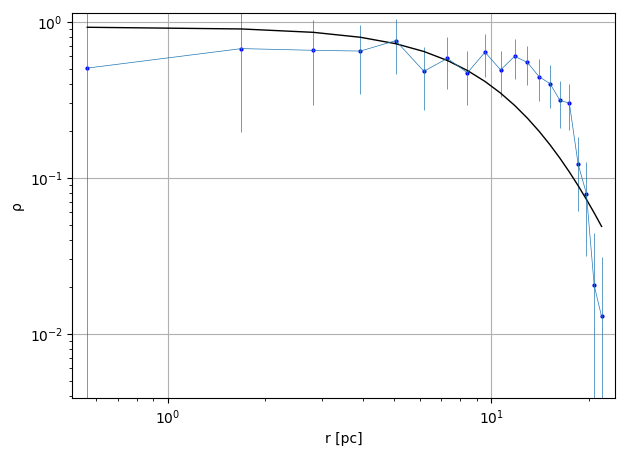

## metasolution:
_modelCauchy(0.9217089758612436, 18.026489143094445, 3.236316476111078)
## Fit error:
_modelCauchy(0.053092665024369684, 1.5650314677756938, 0.48168432340819634)


In [35]:
## binned density
r2d,ρ2d,err2d= _density2D(oc.Y, oc.Z, nbin)    ## binned radius
## local density
nloc= 2
rad_2d, loc_2d= _locdens2d(oc.Y, oc.Z, nloc)    ## density estimated for each point
 
ρ2dfit= _model_rad(r2d, θfit, _fdens1)

fig= PyPlot.figure(figsize=(7,5))

ax= PyPlot.subplot(111)
ax.set_xlabel("r [pc]")
ax.set_ylabel("ρ")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.3,maximum(ρ2d)*1.5)
PyPlot.grid("on")
PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
# PyPlot.scatter(rad_2d, loc_2d , s=2, facecolor="red" )
PyPlot.plot(r2d, ρ2dfit, "k-", linewidth=1)

PyPlot.show()

println("## metasolution:")
println(θfit)
println("## Fit error:")
println(θfiterr)

-----------------------------------
## Loop over all OCs
### !!!! the fixed version is in /src !!

In [36]:
cd(ocdir)
files= glob("*csv")
cd(wdir)

ilabel= []

doIt= false
i= 0
for f in files
    i+= 1
    # oc= CSV.read("$ocdir/$f" , delim= ";")
    ocfile= "$ocdir/$f"
    println("## ocfile: $f")
    println("## fitting the radial profile....")
    
    ntest= 50 ; nbin=20 ; niter=50000
    if doIt
        θfit, θfiterr= _extract_parameter(ocfile, ntest, nbin, niter, true)
        
        println(θfit)
        println(θfiterr)
        println(" ")
        push!(ilabel, i) 
    end
    

end


## ocfile: ASCC 10-2.7deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 100-1.8deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 101-2.5deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 103-1.4deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 108-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 11-2.0deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 113-1.7deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 114-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 115-1.1deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 118-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 12-1.1deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 120-1.1deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 122-2.8deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 124-1.6deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 125-2.8deg-oc.csv
## fitting the ra

## fitting the radial profile....
## ocfile: FSR 1281-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1284-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1289-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1326-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1378-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1379-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1387-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1411-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1418-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1424-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1432-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1435-1.2deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1441-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1442-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR

## ocfile: NGC 3228-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 3532-2.1deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 3572-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 3680-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 381-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 4103-1.1deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 433-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 4609-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 4852-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 5269-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 5281-1.1deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 5316-1.3deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 5460-1.9deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 5662-1.2deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 5822-2.8deg-oc.csv
## fitting the r